# Spracherkennung

Dieses Jupyter Notebook dient dazu die in den Lyrics aufkommenden Sprachen etwas näher zu analysieren. Dabei haben wir uns zuerst auf nicht-deutsche Lyrics fokussiert und uns später etwas genauer auf die Sprachen Englisch und Türkisch angeschaut. Ziel ist es herauszufinden, welche Fremdsprachen am häufigsten auftreten und in welchen genres sie auftauchen. Hierbei wird das Jupyter Notebook in folgende Unterthemen aufgeteilt:

- Wie deutsch sind deutsche Songs?
- Wie verteilen sich die Sprachen pro genre?
    - Top 10 Sprachen
    - Welches genre weist die meisten englischen/türkischen Lyrics auf?

### Setup

In [4]:
import pandas as pd
import spacy
import spacy.cli
# spacy.cli.download("de_core_news_lg")
# spacy.cli.download("de_core_news_md")
from spacy.language import Language
from spacy_language_detection import LanguageDetector
from spacy.tokens import Doc

In [5]:
df = pd.read_csv("../data/songs_complete_final.csv")

für jede der drei Sprachen haben ein Modell geladen, um die Texte dementsprechen zu verarbeiten und zu analysieren

In [13]:
# deutsches Modell
nlp_de = spacy.load("de_core_news_md")
words_de = set(nlp_de.vocab.strings)

def get_lang_detector_de(nlp, name):
    return LanguageDetector()

In [7]:
# englisches Modell
nlp_en = spacy.load("en_core_web_sm")
words_en = set(nlp_en.vocab.strings)

def get_lang_detector_en(nlp, name):
    return LanguageDetector()

In [8]:
# trainiertes Modell von Github https://github.com/spacyturk/spacyturk
import spacyturk

# türkisches Modell
nlp_tr = spacy.load("tr_floret_web_md")
words_tr = set(nlp_tr.vocab.strings)

def get_lang_detector_tr(nlp, name):
    return LanguageDetector()

In [9]:
Language.factory("language_detector_de", func=get_lang_detector_de)
Language.factory("language_detector_en", func=get_lang_detector_en)

nlp_de.add_pipe('language_detector_de', last=True)
nlp_en.add_pipe('language_detector_en', last=True)

In [10]:
Language.factory("language_detector_tr", func=get_lang_detector_tr)
nlp_tr.add_pipe('language_detector_en', last=True)
# Error: "Sentence boundaries unset. You can add the 'sentencizer' component"
nlp_tr.add_pipe('sentencizer')


In [11]:
nlp_tr.add_pipe('language_detector_tr', last=True)
# Error: "Sentence boundaries unset. You can add the 'sentencizer' component"
#nlp_tr.add_pipe('sentencizer')

### Wie deutsch sind deutsche Songs?

Die Spracherkennung setzen wir auf die Lyrics an, indem wir mit spacy herausfiltern, welche Sätze in den Songtexten nicht deutsch sind. Da es oft vorkommt, dass Sprachen nicht erkannt werden, wurden die unbekannten Werte entfernt. Ausgegeben sollen unter anderem Songtitel, vorkommende Fremdsprachen, Score, Genre und Lyrics werden. Anfangs bestand die Idee, die Sprachen vielleicht nach score auszugeben, um zu schauen welche Sprache den höchsten Score hat, allerdings wurde der Score letztendlich nicht mehr aufgegriffen.

Ein Problem, welches die ganze Zeit besteht ist, dass Sprachen oft falscht eingeschätzt werden. So war der Anteil für die Sprache Afrikaans beim ersten Durchlauf unrealistisch hoch, da es den Anteil für englischsprachige Sätze übertroffen hatte. Für die Sprache Englisch konnte eine von spacy vordefiniertes Sprachmodell zur Überprüfung eingesetzt werden. Für die nicht-deutschen Lyrics würde es wiederrum keinen Einfluss haben, da sehr viele Sprachen vorhanden sind und man nicht das deutsche spacy.vocab einsetzen kann.

In [14]:
non_ger_results = []
count = 0

# without Unkown
for idx, row in df.iterrows():
    # if count >= 100:
    #     break
    text = row['lyrics']
    doc = nlp_de(text)
    # nicht-deutsche Sätze
    non_german_sents = [sent for sent in doc.sents if sent._.language['language'] != 'de' and sent._.language['language'] != 'UNKNOWN']
    if len(non_german_sents) > 0:
        song_title = row['title']
        lyric_num = idx
        languages = []
        scores = []
        lyrics = []
        for sent in non_german_sents:
            lang = sent._.language['language']
            score = sent._.language['score']
            words_not_in_de = [token.text.lower() for token in sent if token.text.lower() not in words_de]
            if words_not_in_de:
                languages.append(lang)
                scores.append(score)
                lyrics.append(sent.text)
        if len(languages) > 0:
            # Ergebnisse ins dictionary speichern
            result = {
                'song_title': song_title,
                'lyric_num': lyric_num,
                'languages': set(languages),
                'scores': scores,
                'genre': row['genre'],
                'lyrics': lyrics
            }
            non_ger_results.append(result)
            # print(result)
            count += 1

In [15]:
import plotly.express as px

non_ger_genre_count = pd.DataFrame(non_ger_results).groupby(['genre']).size().reset_index(name='count')

fig = px.bar(non_ger_genre_count, x='genre', y='count', title='Verteilung der nicht-deutschen Lyrics',
             labels={'count': 'Anzahl'})

fig.show()
fig.write_html("../images/non_german_lyrics.html")

In [16]:
non_ger_df = pd.DataFrame(non_ger_results)

Anschließend wurde ein dataframe erstellt, in dem die Songs mit ihren Sprachen, Score und die Lyrics, die unterschiedliche Srpache beinhalten, dargestellt sind. Auch hier kann man fälschlicherweise erkennen, dass der Song "BUNDESWEIT" als französich anerkannt wurde für die Lyric "lieb Chaos", auch wenn der Score dafür mit 0.57 im Mittelbereich liegt.

In [17]:
non_ger_df

,song_title,lyric_num,languages,scores,genre,lyrics
0,HOLLANDA,3,{en},[0.9999974585227126],post-rock,[can be And manys the time That ]
1,MOON,4,"{ca, fr, it, en, fi, ro}","[0.5714296019467853, 0.2857145184756181, 0.999...",post-rock,"[Liquid Swords GZA Actual ., souljaboytellem..."
2,KILLA,5,"{en, no, tr}","[0.7142839683615658, 0.9999966244358256, 0.999...",post-rock,"[Im finna do this for my niggas, mane Its the ..."
3,SYSTEM,6,{et},[0.5714272094399417],post-rock,[Dann kontakt mit nem Jibbet]
4,ALL BLACK,7,"{en, af, tl, id}","[0.9999987655780637, 0.9999956866933137, 0.857...",post-rock,[Im busy at the moment U may call the receptio...
...,...,...,...,...,...,...
4347,Polen,17748,{pl},"[0.9999980552727459, 0.9999970379411062]",hip-hop,"[Ja, Tyskie, ja, Tyskie, ich sipp mich dicht, ..."
4348,40 Nights,17749,{pl},[0.5714285280076067],hip-hop,[Yeezys]
4349,Fast,17750,{en},[0.9999956046086005],hip-hop,"[Kozee, cooke die Sauce Ich bin fast fully ta..."
4350,Fliegt,17751,{en},[0.9999957837694141],hip-hop,"[Rope God, youre so anorexic ]"


In [18]:
genre_languages_count = non_ger_df.explode('languages').groupby(['genre', 'languages']).size().reset_index(name='count')

fig = px.bar(genre_languages_count, x='genre', y='count', color='languages', title='Sprachen pro Genre',
             category_orders={'genre': df['genre'].unique()},
             labels={'count': 'Anzahl'})
fig.show()
fig.write_html("../images/language_per_genre.html")

Zu erkennen ist, dass die Genres in Richtung Hip-Hop und Rap einen hohen Fremdsprachenanteil haben. Überraschenderweise liegt der Anteil der Fremdsprachen im genre Schlager relativ weit oben. Desweiteren sollen die am häufigsten auftauchenden Sprachen dargestellt werden.

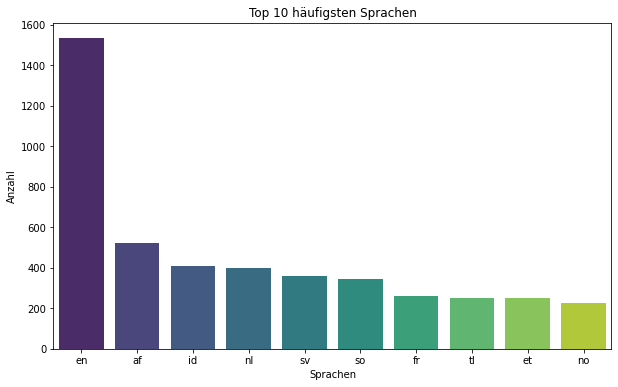

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Zählen der häufigsten Sprachen pro Genre
top_languages = non_ger_df['languages'].explode().value_counts().nlargest(10)

# Visualisierung
plt.figure(figsize=(10, 6))
sns.barplot(x=top_languages.index, y=top_languages.values, palette='viridis')
plt.title('Top 10 häufigsten Sprachen')
plt.xlabel('Sprachen')
plt.ylabel('Anzahl')
plt.show()

In [20]:
import plotly.graph_objs as go

fig = go.Figure(data=[go.Pie(labels=top_languages.index, values=top_languages.values)])

fig.update_layout(title='Top 10 vorkommende Sprachen in den deutschen Songs')
fig.show()

fig.write_html("../images/top_ten_languages_pie.html")


### Welches genre weist die meisten englischen/türkischen Lyrics auf?

In [42]:
results = []
count = 0

for idx, row in df.iterrows():
    # if count >= 100:
    #     break
    text = row['lyrics']
    doc = nlp_en(text)
    # englische Sätze
    eng_sents = [sent for sent in doc.sents if sent._.language['language'] == 'en']
    if len(eng_sents) > 0:
        song_title = row['title']
        lyric_num = idx
        languages = []
        scores = []
        lyrics = []
        for sent in eng_sents:
            lang = sent._.language['language']
            score = sent._.language['score']
            # Wörter vom Spacy Vocab
            words_in_sentence = [token.text.lower() for token in sent if token.text.lower() in words_en]
            if words_in_sentence:
                languages.append(lang)
                scores.append(score)
                lyrics.append(sent.text)
        if len(languages) > 0:
            # Ergebnisse ins dictionary speichern
            result = {
                'song_title': song_title,
                'lyric_num': lyric_num,
                'languages': languages,
                'scores': scores,
                'genre': row['genre'],
                'lyrics': lyrics
            }
            results.append(result)
            # print(result)
            count += 1

{'song_title': 'HOLLANDA', 'lyric_num': 3, 'languages': ['en', 'en'], 'scores': [0.999998993314676, 0.9999962463339593], 'genre': 'post-rock', 'lyrics': ['Because youre so sweet You lift up my heart And Ill fall back again But I dont know Quite\u2005which\u2005way to turn  The\u2005light in your eyes Touches the sky', 'And you hold me As close as close\u205fcan\u205fbe  And\u205fmanys the time That\u205fyouve enchanted me I\u205fwant you back Here in my loving arms For eternity   You look and you smile Warm me inside Cause youre so good to me A beauty Filled with the joys of spring']}
{'song_title': 'MOON', 'lyric_num': 4, 'languages': ['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en'], 'scores': [0.5714296019467853, 0.9999970011004629, 0.9999964108479886, 0.9999952002663299, 0.999994292495005, 0.9999967490840389, 0.999996

In [129]:
eng_genre_count = pd.DataFrame(results).groupby(['genre']).size().reset_index(name='count')

fig = px.bar(eng_genre_count, x='genre', y='count', title='Verteilung der englischen Lyrics',
             labels={'count': 'Anzahl'})

fig.show()

fig.write_html("../images/eng_lyrics.html")

Englischsprachige Lyrics sind vor allem in den genres Rap, Post-rock und Pop vertreten. Obwohl Deutsch Rap über 4.000 Songs im Datenset hat, mehr als Pop und Rap zusammen, und durchschnittlich die gleiche Lyriclänge zu Rap besitzt, fällt der englische Anteil deutlich geringer aus als bei Rap. Damit weist der Genre Rap die meisten englischen Lyrics auf.

In dem Datenset wurden wiederrum weniger Songs mit türkischen Lyrics aufgefunden; die meisten wurden dem Genre Rock zugeteilt mit vier Songs. Deutschrap hat im zweiten Platz verglichen dazu nur zwei türkischsprachige Lyrics.

In [14]:
df_results = pd.DataFrame(tr_results)
genre_count = df_results.groupby(['genre']).size().reset_index(name='count')

fig = px.bar(genre_count, x='genre', y='count', title='Verteilung der Türkisch-sprachigen Lyrics',
             category_orders={'genre': df_results['genre'].unique()},
             labels={'count': 'Anzahl'})
fig.show()

fig.write_html("../images/tr_lyrics.html")

In [11]:
tr_results = []
count = 0

for idx, row in df.iterrows():
    # if count >= 100:
    #     break
    text = row['lyrics']
    doc = nlp_tr(text)
    # türkische Sätze
    tr_sents = [sent for sent in doc.sents if sent._.language['language'] == 'tr']
    if len(tr_sents) > 0:
        song_title = row['title']
        lyric_num = idx
        languages = []
        scores = []
        lyrics = []
        for sent in tr_sents:
            lang = sent._.language['language']
            score = sent._.language['score']
            # Wörter vom Spacy Vocab
            words_in_sentence = [token.text.lower() for token in sent if token.text.lower() in words_tr]
            if words_in_sentence:
                languages.append(lang)
                scores.append(score)
                lyrics.append(sent.text)
        if len(languages) > 0:
            # Ergebnisse ins dictionary speichern
            result = {
                'song_title': song_title,
                'lyric_num': lyric_num,
                'languages': languages,
                'scores': scores,
                'genre': row['genre'],
                'lyrics': lyrics
            }
            tr_results.append(result)
            print(result)
            count += 1

{'song_title': 'MOON', 'lyric_num': 4, 'languages': ['tr'], 'scores': [0.9999950211281952], 'genre': 'post-rock', 'lyrics': ['Dare iz a Darkside  Redman  .']}
{'song_title': 'Yakuza', 'lyric_num': 2219, 'languages': ['tr'], 'scores': [0.999995201267063], 'genre': 'rock', 'lyrics': ['Yat uzan El Chapo gibi Cem Uzan Dolandırma lafı paket oldun hadi len yürü koğuşa Marrakesh owdooha paparazi ghettostar Huh süner karılar ay siktir kültürlü nonoşlar Godoşlar siksin sizi bizde komşu var son durak  plakam Sordurma Çalar Neşet Baba tespihim oltu bak Gecekondu ganstazz frrrh karanlık etraf Grrrr gezeriz çarşı pazar bul ucuz sat  bin dolar Allah değdirmesin nazar aman değdirmesin nazar Biri gelip vurur sonra kardeşleri yatar Run bitch run belaboyz barikat press press Panik var cash cash Hannibal yes Hazır sativam değil bura argentina Patküt hadi naş yuvarlan papik at Yükseltepe favelaz yok burda coffeshop Cebim yine delik bro wubba lubba paff lemon sag nigcht baba sido grr  city pust tayfam yaku